## Seminar and homework (10 points total)

Today we shall compose encoder-decoder neural networks and apply them to the task of machine translation.

![img](https://esciencegroup.files.wordpress.com/2016/03/seq2seq.jpg)
_(img: esciencegroup.files.wordpress.com)_


Encoder-decoder architectures are about converting anything to anything, including
 * Machine translation and spoken dialogue systems
 * [Image captioning](http://mscoco.org/dataset/#captions-challenge2015) and [image2latex](https://openai.com/requests-for-research/#im2latex) (convolutional encoder, recurrent decoder)
 * Generating [images by captions](https://arxiv.org/abs/1511.02793) (recurrent encoder, convolutional decoder)
 * Grapheme2phoneme - convert words to transcripts

## Our task: machine translation

We gonna try our encoder-decoder models on russian to english machine translation problem. More specifically, we'll translate hotel and hostel descriptions. This task shows the scale of machine translation while not requiring you to train your model for weeks if you don't use GPU.

Before we get to the architecture, there's some preprocessing to be done. ~~Go tokenize~~ Alright, this time we've done preprocessing for you. As usual, the data will be tokenized with WordPunctTokenizer.

However, there's one more thing to do. Our data lines contain unique rare words. If we operate on a word level, we will have to deal with large vocabulary size. If instead we use character-level models, it would take lots of iterations to process a sequence. This time we're gonna pick something inbetween.

One popular approach is called [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt) aka __BPE__. The algorithm starts with a character-level tokenization and then iteratively merges most frequent pairs for N iterations. This results in frequent words being merged into a single token and rare words split into syllables or even characters.



In [6]:
!pip3 install torch>=1.3.0
!pip3 install subword-nmt &> log
!wget https://www.dropbox.com/s/yy2zqh34dyhv07i/data.txt?dl=1 -O data.txt
!wget https://raw.githubusercontent.com/yandexdataschool/nlp_course/2020/week04_seq2seq/vocab.py -O vocab.py
# thanks to tilda and deephack teams for the data, Dmitry Emelyanenko for the code :)

--2023-06-05 09:57:53--  https://www.dropbox.com/s/yy2zqh34dyhv07i/data.txt?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/yy2zqh34dyhv07i/data.txt [following]
--2023-06-05 09:57:53--  https://www.dropbox.com/s/dl/yy2zqh34dyhv07i/data.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc2fc9cb9a99ec66a707cc63ffa.dl.dropboxusercontent.com/cd/0/get/B9bTFq18EYyA70mxIz5EnDYb9FqB1OjlUhN3Pyi_iElEmVfkJt_L9P5kFMAbEVNmP4ZnwHWL97NstOYSFV3IsaQi4grQaAPdB6KNVbjKaFpug97B-2pFVXISSwnCU_ExFeY6bvFA7ZK8c6T3U-gNCHCslbMFRbBaUq9BzoW268q8vw/file?dl=1# [following]
--2023-06-05 09:57:54--  https://ucc2fc9cb9a99ec66a707cc63ffa.dl.dropboxusercontent.com/cd/0/get/B9bTFq18EYyA70mxIz5EnDYb9FqB1OjlUhN3Pyi_iElEmVfkJt_L9P5kFMAbEVNmP4ZnwHWL97NstOYSFV3IsaQ

In [7]:
from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE
tokenizer = WordPunctTokenizer()
def tokenize(x):
    return ' '.join(tokenizer.tokenize(x.lower()))

# split and tokenize the data
with open('train.en', 'w') as f_src,  open('train.ru', 'w') as f_dst:
    for line in open('data.txt'):
        src_line, dst_line = line.strip().split('\t')
        f_src.write(tokenize(src_line) + '\n')
        f_dst.write(tokenize(dst_line) + '\n')

# build and apply bpe vocs
bpe = {}
for lang in ['en', 'ru']:
    learn_bpe(open('./train.' + lang), open('bpe_rules.' + lang, 'w'), num_symbols=8000)
    bpe[lang] = BPE(open('./bpe_rules.' + lang))
    
    with open('train.bpe.' + lang, 'w') as f_out:
        for line in open('train.' + lang):
            f_out.write(bpe[lang].process_line(line.strip()) + '\n')

100%|██████████| 8000/8000 [00:09<00:00, 875.13it/s]


### Building vocabularies

We now need to build vocabularies that map strings to token ids and vice versa. We're gonna need these fellas when we feed training data into model or convert output matrices into words.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm import tqdm, trange
%matplotlib inline

In [9]:
data_inp = np.array(open('./train.bpe.ru').read().split('\n'))
data_out = np.array(open('./train.bpe.en').read().split('\n'))

from sklearn.model_selection import train_test_split
train_inp, dev_inp, train_out, dev_out = train_test_split(data_inp, data_out, test_size=3000,
                                                          random_state=42)
for i in range(3):
    print('inp:', train_inp[i])
    print('out:', train_out[i], end='\n\n')

inp: на территории обустроена бесплатная частная парковка .
out: free private parking is available on site .

inp: кроме того , в 5 минутах ходьбы работают многочисленные бары и рестораны .
out: guests can find many bars and restaurants within a 5 - minute walk .

inp: отель san mi@@ gu@@ el расположен в центре мор@@ ели@@ и , в 750 метрах от главной площади города и кафедрального собора .
out: hotel san miguel is located in central more@@ lia , 750 metres from the city ’ s main square and cathedral .



In [10]:
from vocab import Vocab
inp_voc = Vocab.from_lines(train_inp)
out_voc = Vocab.from_lines(train_out)

In [6]:
# Here's how you cast lines into ids and backwards.
batch_lines = sorted(train_inp, key=len)[5:10]
batch_ids = inp_voc.to_matrix(batch_lines)
batch_lines_restored = inp_voc.to_lines(batch_ids)

print("lines")
print(batch_lines)
print("\nwords to ids (0 = bos, 1 = eos):")
print(batch_ids)
print("\nback to words")
print(batch_lines_restored)

lines
['гостевой дом r .', 'до афин — 20 км .', 'работает боулинг .', 'оборудован балкон .', 'подключен wi - fi .']

words to ids (0 = bos, 1 = eos):
tensor([[   0, 2688, 2943, 1108,   29,    1,    1,    1],
        [   0, 2922, 1834, 8035,   59, 3800,   29,    1],
        [   0, 6030, 2083,   29,    1,    1,    1,    1],
        [   0, 4927, 1870,   29,    1,    1,    1,    1],
        [   0, 5549, 1453,   27,  592,   29,    1,    1]])

back to words
['гостевой дом r .', 'до афин — 20 км .', 'работает боулинг .', 'оборудован балкон .', 'подключен wi - fi .']


Draw source and translation length distributions to estimate the scope of the task.

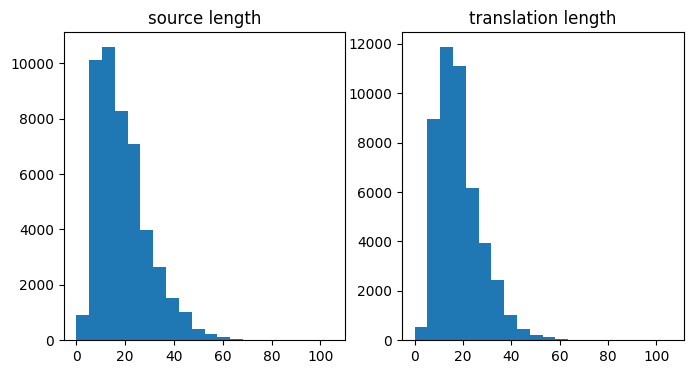

In [7]:
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(map(len, map(str.split, train_inp))), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(map(len, map(str.split, train_out))), bins=20);

### Encoder-decoder model

The code below contains a template for a simple encoder-decoder model: single GRU encoder/decoder, no attention or anything. This model is implemented for you as a reference and a baseline for your homework assignment.

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [12]:
device

'cuda'

In [67]:
class BasicModel(nn.Module):
    def __init__(self, inp_voc, out_voc, emb_size=64, hid_size=128):
        """
        A simple encoder-decoder seq2seq model
        """
        super().__init__() # initialize base class to track sub-layers, parameters, etc.

        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size
        
        self.emb_inp = nn.Embedding(len(inp_voc), emb_size)
        self.emb_out = nn.Embedding(len(out_voc), emb_size)
        self.enc0 = nn.GRU(emb_size, hid_size, batch_first=True)

        self.dec_start = nn.Linear(hid_size, hid_size)
        self.dec0 = nn.GRUCell(emb_size, hid_size)
        self.logits = nn.Linear(hid_size, len(out_voc))
        
    def forward(self, inp, out):
        """ Apply model in training mode """
        initial_state = self.encode(inp)
        return self.decode(initial_state, out)


    def encode(self, inp, **flags):
        """
        Takes symbolic input sequence, computes initial state
        :param inp: matrix of input tokens [batch, time]
        :returns: initial decoder state tensors, one or many
        """
        inp_emb = self.emb_inp(inp)
        batch_size = inp.shape[0]
        
        enc_seq, [last_state_but_not_really] = self.enc0(inp_emb)
        # enc_seq: [batch, time, hid_size], last_state: [batch, hid_size]
        
        # note: last_state is not _actually_ last because of padding, let's find the real last_state
        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)
       
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]
        # ^-- shape: [batch_size, hid_size]
        
        
        dec_start = self.dec_start(last_state)

        return [dec_start]

    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Takes previous decoder state and tokens, returns new state and logits for next tokens
        :param prev_state: a list of previous decoder state tensors, same as returned by encode(...)
        :param prev_tokens: previous output tokens, an int vector of [batch_size]
        :return: a list of next decoder state tensors, a tensor of logits [batch, len(out_voc)]
        """
        prev_gru0_state = prev_state[0]
        out_emb = self.emb_out(prev_tokens)
        new_dec_state = self.dec0(out_emb, prev_gru0_state)
        output_logits = self.logits(new_dec_state)
        
        return [new_dec_state], output_logits

    def decode(self, initial_state, out_tokens, **flags):
        """ Iterate over reference tokens (out_tokens) with decode_step """
        batch_size = out_tokens.shape[0]
        state = initial_state
        
        # initial logits: always predict BOS
        onehot_bos = F.one_hot(torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64),
                               num_classes=len(self.out_voc)).to(device=out_tokens.device)
        first_logits = torch.log(onehot_bos.to(torch.float32) + 1e-9)
        
        logits_sequence = [first_logits]
        for i in range(out_tokens.shape[1] - 1):
            state, logits = self.decode_step(state, out_tokens[:, i])
            logits_sequence.append(logits)
        return torch.stack(logits_sequence, dim=1)

    def decode_inference(self, initial_state, max_len=100, **flags):
        """ Generate translations from model (greedy version) """
        batch_size, device = len(initial_state[0]), initial_state[0].device
        state = initial_state
        outputs = [torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64, 
                              device=device)]
        all_states = [initial_state]

        for i in range(max_len):
            state, logits = self.decode_step(state, outputs[-1])
            outputs.append(logits.argmax(dim=-1))
            all_states.append(state)
        
        return torch.stack(outputs, dim=1), all_states

    def translate_lines(self, inp_lines, **kwargs):
        inp = self.inp_voc.to_matrix(inp_lines).to(device)
        initial_state = self.encode(inp)
        out_ids, states = self.decode_inference(initial_state, **kwargs)
        return self.out_voc.to_lines(out_ids.cpu().numpy()), states


In [68]:
# debugging area
model = BasicModel(inp_voc, out_voc).to(device)

dummy_inp_tokens = inp_voc.to_matrix(sorted(train_inp, key=len)[5:10]).to(device)
dummy_out_tokens = out_voc.to_matrix(sorted(train_out, key=len)[5:10]).to(device)

h0 = model.encode(dummy_inp_tokens)
h1, logits1 = model.decode_step(h0, torch.arange(len(dummy_inp_tokens), device=device))

assert isinstance(h1, list) and len(h1) == len(h0)
assert h1[0].shape == h0[0].shape and not torch.allclose(h1[0], h0[0])
assert logits1.shape == (len(dummy_inp_tokens), len(out_voc))

logits_seq = model.decode(h0, dummy_out_tokens)
assert logits_seq.shape == (dummy_out_tokens.shape[0], dummy_out_tokens.shape[1], len(out_voc))

# full forward
logits_seq2 = model(dummy_inp_tokens, dummy_out_tokens)
assert logits_seq2.shape == logits_seq.shape

In [ ]:
dummy_translations, dummy_states = model.translate_lines(train_inp[:3], max_len=25)
print("Translations without training:")
print('\n'.join([line for line in dummy_translations]))

Translations without training:
63 uger mel@@ rock@@ ne abdul condomini@@ wonder@@ gage cap reserved á ese ese girona shops loungers immedi@@ elos village summertime dü@@ sailing than@@ ails
esh@@ á jun@@ uger lanzarote hot@@ zi ross@@ lana having hand metres bali prac@@ à@@ than@@ syd@@ atory exerc@@ heat@@ lodge brid@@ otel cia bing
sacré cali@@ ik aarhus zin@@ ass tle lift paved champag@@ chicago cavtat í@@ cino ene rong gren evo nikola@@ botanical ge hn@@ õ@@ civic eval


### Training loss (2 points)

Our training objective is almost the same as it was for neural language models:
$$ L = {\frac1{|D|}} \sum_{X, Y \in D} \sum_{y_t \in Y} - \log p(y_t \mid y_1, \dots, y_{t-1}, X, \theta) $$

where $|D|$ is the __total length of all sequences__, including BOS and first EOS, but excluding PAD.

In [14]:

def compute_loss(model, inp, out, **flags):
    """
    Compute loss (float32 scalar) as in the formula above
    :param inp: input tokens matrix, int32[batch, time]
    :param out: reference tokens matrix, int32[batch, time]
    
    In order to pass the tests, your function should
    * include loss at first EOS but not the subsequent ones
    * divide sum of losses by a sum of input lengths (use voc.compute_mask)
    """
    mask = model.out_voc.compute_mask(out) # [batch_size, out_len]
    targets_1hot = F.one_hot(out, len(model.out_voc)).to(torch.float32)
    
    # outputs of the model, [batch_size, out_len, num_tokens]
    logits_seq = model(inp, out)
    
    
    log_softmax =  nn.LogSoftmax(dim=2)

    # log-probabilities of all tokens at all steps, [batch_size, out_len, num_tokens]
    logprobs_seq = (-1) * log_softmax(logits_seq)
    
   
    # log-probabilities of correct outputs, [batch_size, out_len]
    logp_out = (logprobs_seq * targets_1hot).sum(dim=-1)
    # ^-- this will select the probability of the actual next token.
    # Note: you can compute loss more efficiently using using F.cross_entropy
    
    loss = (logp_out * mask).sum() / mask.sum()

    # average cross-entropy over tokens where mask == True
    return loss # average loss, scalar

In [13]:
dummy_loss = compute_loss(model, dummy_inp_tokens, dummy_out_tokens)
print("Loss:", dummy_loss)
assert np.allclose(dummy_loss.item(), 7.5, rtol=0.1, atol=0.1), "We're sorry for your loss"

# test autograd
dummy_loss.backward()
for name, param in model.named_parameters():
    assert param.grad is not None and abs(param.grad.max()) != 0, f"Param {name} received no gradients"

Loss: tensor(7.5156, device='cuda:0', grad_fn=<DivBackward0>)


### Evaluation: BLEU

Machine translation is commonly evaluated with [BLEU](https://en.wikipedia.org/wiki/BLEU) score. This metric simply computes which fraction of predicted n-grams is actually present in the reference translation. It does so for n=1,2,3 and 4 and computes the geometric average with penalty if translation is shorter than reference.

While BLEU [has many drawbacks](http://www.cs.jhu.edu/~ccb/publications/re-evaluating-the-role-of-bleu-in-mt-research.pdf), it still remains the most commonly used metric and one of the simplest to compute.

In [15]:
from nltk.translate.bleu_score import corpus_bleu
def compute_bleu(model, inp_lines, out_lines, bpe_sep='@@ ', **flags):
    """
    Estimates corpora-level BLEU score of model's translations given inp and reference out
    Note: if you're serious about reporting your results, use https://pypi.org/project/sacrebleu
    """
    with torch.no_grad():
        translations, _ = model.translate_lines(inp_lines, **flags)
        translations = [line.replace(bpe_sep, '') for line in translations]
        actual = [line.replace(bpe_sep, '') for line in out_lines]
        return corpus_bleu(
            [[ref.split()] for ref in actual],
            [trans.split() for trans in translations],
            smoothing_function=lambda precisions, **kw: [p + 1.0 / p.denominator for p in precisions]
            ) * 100

In [15]:
compute_bleu(model, dev_inp, dev_out)

0.0019345697519422042

### Training loop

Training encoder-decoder models isn't that different from any other models: sample batches, compute loss, backprop and update

In [16]:
def train_model(model, n_steps=25000, batch_size=32):
    metrics = {'train_loss': [], 'dev_bleu': [] }
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    for _ in trange(n_steps):
        step = len(metrics['train_loss']) + 1
        batch_ix = np.random.randint(len(train_inp), size=batch_size)
        batch_inp = inp_voc.to_matrix(train_inp[batch_ix]).to(device)
        batch_out = out_voc.to_matrix(train_out[batch_ix]).to(device)
    
        opt.zero_grad()
        loss_t = compute_loss(model, batch_inp, batch_out)
        loss_t.backward()
        opt.step()
    
        metrics['train_loss'].append((step, loss_t.item()))
    
        if step % 100 == 0:
            metrics['dev_bleu'].append((step, compute_bleu(model, dev_inp, dev_out)))
        
            clear_output(True)
            plt.figure(figsize=(12,4))
            for i, (name, history) in enumerate(sorted(metrics.items())):
                plt.subplot(1, len(metrics), i + 1)
                plt.title(name)
                plt.plot(*zip(*history))
                plt.grid()
            plt.show()
            print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)
    return metrics
    
    

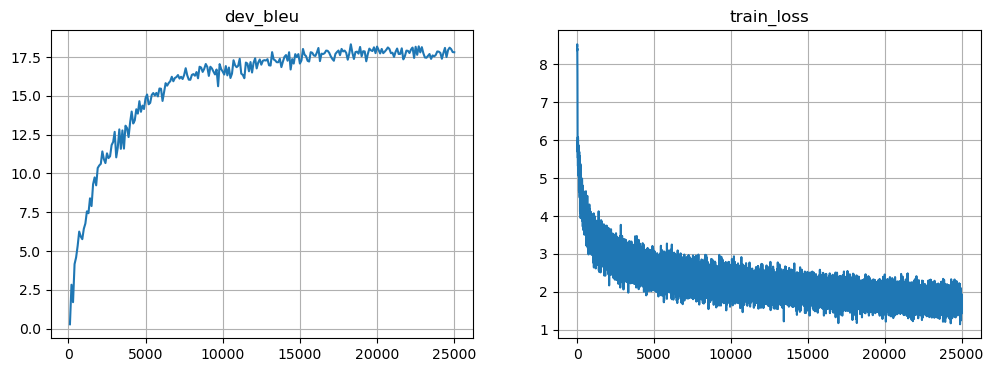

Mean loss=1.710


100%|██████████| 25000/25000 [19:57<00:00, 20.87it/s]


In [ ]:
model = BasicModel(inp_voc, out_voc).to(device)
metrics = train_model(model)

In [ ]:
assert np.mean(metrics['dev_bleu'][-10:], axis=0)[1] > 15, "We kind of need a higher bleu BLEU from you. Kind of right now."

### Final BLEU of the simple model

In [ ]:
compute_bleu(model, dev_inp, dev_out)

17.81643237010111

In [ ]:
for inp_line, trans_line in zip(dev_inp[::500], model.translate_lines(dev_inp[::500])[0]):
    print(inp_line)
    print(trans_line)
    print()

в распоряжении гостей общая кухня и общая гостиная .
there is a shared kitchen and a shared kitchen .

кроме того , предоставляется прокат велосипедов , услуги трансфера и бесплатная парковка .
a free shuttle service and a shuttle service can be arranged for free .

расстояние до города ки@@ сси@@ м@@ ми составляет 26 км .
the hinter@@ tu@@ x train station is 26 km away .

апартаменты в пент@@ хаусе с общим открытым бассейном , садом , кондиционером и террасой для загара расположены в 5 минутах ходьбы от пляжа на курорте ка@@ бо - рой .
located a 5 - minute walk from the beach , villa and@@ aman beach offers air - conditioned accommodation with a balcony . the property is equipped with a children ’ s playground and a terrace .

апартаменты mo@@ s@@ co@@ w point - loft red square находятся в москве , в 200 метрах от большого театра .
suit@@ s intern@@ acional is located 200 metres from the centre of zakopane and 400 metres from diocletian ' s palace .

в вашем распоряжении собственная в

### Your Attention Required

In this section we want you to improve over the basic model by implementing a simple attention mechanism.

This is gonna be a two-parter: building the __attention layer__ and using it for an __attentive seq2seq model__.

### Attention layer (3 points)

Here you will have to implement a layer that computes a simple additive attention:

Given encoder sequence $ h^e_0, h^e_1, h^e_2, ..., h^e_T$ and a single decoder state $h^d$,

* Compute logits with a 2-layer neural network
$$a_t = linear_{out}(tanh(linear_{e}(h^e_t) + linear_{d}(h_d)))$$
* Get probabilities from logits, 
$$ p_t = {{e ^ {a_t}} \over { \sum_\tau e^{a_\tau} }} $$

* Add up encoder states with probabilities to get __attention response__
$$ attn = \sum_t p_t \cdot h^e_t $$

You can learn more about attention layers in the lecture slides or [from this post](https://distill.pub/2016/augmented-rnns/).

In [19]:
class AttentionLayer(nn.Module):
    def __init__(self, name, enc_size, dec_size, hid_size, activ=torch.tanh):
        """ A layer that computes additive attention response and weights """
        super().__init__()
        self.name = name
        self.enc_size = enc_size # num units in encoder state
        self.dec_size = dec_size # num units in decoder state
        self.hid_size = hid_size # attention layer hidden units
        self.activ = activ       # attention layer hidden nonlinearity
        
        # create trainable paramteres like this:
        self.linear_enc = nn.Parameter(torch.FloatTensor(enc_size, hid_size).uniform_(-np.sqrt(1 / enc_size),  np.sqrt(1 / enc_size)), requires_grad=True)
        self.linear_dec = nn.Parameter(torch.FloatTensor(dec_size, hid_size).uniform_(-np.sqrt(1 / dec_size),  np.sqrt(1 / dec_size)), requires_grad=True)
        self.linear_out = nn.Parameter(torch.FloatTensor(hid_size, 1).uniform_(-np.sqrt(1 / hid_size),  np.sqrt(1 / hid_size)), requires_grad=True)
        
        

    def forward(self, enc, dec, inp_mask):
        """
        Computes attention response and weights
        :param enc: encoder activation sequence, float32[batch_size, ninp, enc_size]
        :param dec: single decoder state used as "query", float32[batch_size, dec_size]
        :param inp_mask: mask on enc activatons (0 after first eos), float32 [batch_size, ninp]
        :returns: attn[batch_size, enc_size], probs[batch_size, ninp]
            - attn - attention response vector (weighted sum of enc)
            - probs - attention weights after softmax
        """

        # Compute logits
        dec = dec.reshape(dec.shape[0], 1, dec.shape[1])
        
        lin_dec = torch.matmul(dec, self.linear_dec)
        lin_enc = torch.matmul(enc, self.linear_enc)
        
        logits = torch.matmul(self.activ(lin_enc + lin_dec), self.linear_out).reshape(dec.shape[0], -1)
        
        # Apply mask - if mask is 0, logits should be -inf or -1e9
        # You may need torch.where
        masked_logits = torch.where(inp_mask, logits, -1e9) 

        # Compute attention probabilities (softmax)
        softmax_func = torch.nn.Softmax(dim=1)
        probs = softmax_func(masked_logits).reshape(enc.shape[0], enc.shape[1], 1)


        # Compute attention response using enc and probs
        attn = (enc * probs).sum(dim=1)

        return attn, probs

In [14]:
batch_size = 2
ninp = 15
enc_size = 5
dec_size = 3
enc = torch.randn(batch_size, ninp, enc_size)
dec = torch.randn(batch_size, dec_size)
inp_mask = torch.FloatTensor(batch_size, ninp).uniform_() < 0.8

In [15]:
layer = AttentionLayer('name', enc_size, dec_size, hid_size=200)
attn, probs = layer(enc, dec, inp_mask)

### Seq2seq model with attention (3 points)

You can now use the attention layer to build a network. The simplest way to implement attention is to use it in decoder phase:
![img](https://i.imgur.com/6fKHlHb.png)
_image from distill.pub [article](https://distill.pub/2016/augmented-rnns/)_

On every step, use __previous__ decoder state to obtain attention response. Then feed concat this response to the inputs of next attention layer.

The key implementation detail here is __model state__. Put simply, you can add any tensor into the list of `encode` outputs. You will then have access to them at each `decode` step. This may include:
* Last RNN hidden states (as in basic model)
* The whole sequence of encoder outputs (to attend to) and mask
* Attention probabilities (to visualize)

_There are, of course, alternative ways to wire attention into your network and different kinds of attention. Take a look at [this](https://arxiv.org/abs/1609.08144), [this](https://arxiv.org/abs/1706.03762) and [this](https://arxiv.org/abs/1808.03867) for ideas. And for image captioning/im2latex there's [visual attention](https://arxiv.org/abs/1502.03044)_

In [13]:
class AttentiveModel(BasicModel):
    def __init__(self, name, inp_voc, out_voc,
                 emb_size=64, hid_size=128, attn_size=128):
        """ Translation model that uses attention. See instructions above. """
        nn.Module.__init__(self)  # initialize base class to track sub-layers, trainable variables, etc.
        super().__init__(inp_voc, out_voc)
        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size
        self.attention = AttentionLayer('dec_attention', hid_size, hid_size, hid_size=attn_size)
        self.dec_linear = nn.Linear(2 * hid_size, hid_size)
        
        

    def encode(self, inp, **flags):
        """
        Takes symbolic input sequence, computes initial state
        :param inp: matrix of input tokens [batch, time]
        :return: a list of initial decoder state tensors
        """
        
        # encode input sequence, create initial decoder states
        inp_emb = self.emb_inp(inp)
        batch_size = inp.shape[0]
        enc_seq, [last_state_but_not_really] = self.enc0(inp_emb)
        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]
        dec_start = self.dec_start(last_state)
        dec_start_zeroes = torch.zeros_like(dec_start)
        
        enc_mask = model.inp_voc.compute_mask(inp)
        
        # apply attention layer from initial decoder hidden state
        first_attn_result, first_attn_probas = self.attention(enc_seq, dec_start_zeroes, enc_mask)
        
        # Build first state: include
        # * initial states for decoder recurrent layers
        # * encoder sequence and encoder attn mask (for attention)
        # * make sure that last state item is attention probabilities tensor
        
        first_state = [dec_start, first_attn_result, enc_seq, enc_mask, first_attn_probas]
        return first_state
   
    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Takes previous decoder state and tokens, returns new state and logits for next tokens
        :param prev_state: a list of previous decoder state tensors
        :param prev_tokens: previous output tokens, an int vector of [batch_size]
        :return: a list of next decoder state tensors, a tensor of logits [batch, n_tokens]
        """
        [prev_dec_state, prev_attn_result, enc_seq, enc_mask, prev_attn_probas] = prev_state


        prev_plus_attn = self.dec_linear(torch.cat((prev_attn_result, prev_dec_state), dim = 1))
        
        new_dec_state, output_logits = super().decode_step([prev_plus_attn], prev_tokens)
        
        new_attn_result, new_attn_probas = self.attention(enc_seq, new_dec_state[0], enc_mask)
        
        full_state = [new_dec_state[0], new_attn_result, enc_seq, enc_mask, new_attn_probas]
        return [full_state, output_logits]


In [49]:
# debugging area
model = AttentiveModel('attentive_model',inp_voc, out_voc).to(device)

dummy_inp_tokens = inp_voc.to_matrix(sorted(train_inp, key=len)[5:10]).to(device)
dummy_out_tokens = out_voc.to_matrix(sorted(train_out, key=len)[5:10]).to(device)

h0 = model.encode(dummy_inp_tokens)
h1, logits1 = model.decode_step(h0, torch.arange(len(dummy_inp_tokens), device=device))


logits_seq = model.decode(h0, dummy_out_tokens)
assert logits_seq.shape == (dummy_out_tokens.shape[0], dummy_out_tokens.shape[1], len(out_voc))

# # full forward
logits_seq2 = model(dummy_inp_tokens, dummy_out_tokens)
assert logits_seq2.shape == logits_seq.shape

### Training attentive model

Please reuse the infrastructure you've built for the regular model. I hope you didn't hard-code anything :)

In [18]:
compute_bleu(model, dev_inp, dev_out)

0.001542099570593098

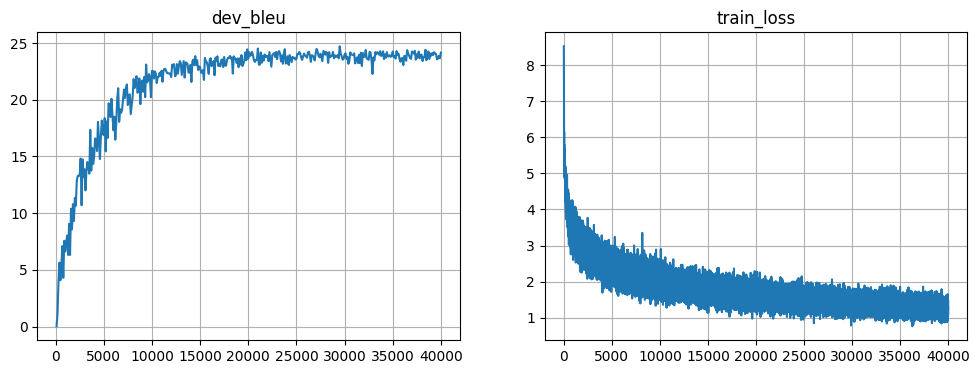

Mean loss=1.256


100%|██████████| 40000/40000 [59:13<00:00, 11.26it/s]


In [19]:
model = AttentiveModel('attentive_model', inp_voc, out_voc).to(device)
metrics = train_model(model, n_steps=40000)

#### Final BLEU of the Attentive model

In [20]:
compute_bleu(model, dev_inp, dev_out)

24.154669416681447

In [21]:
for inp_line, trans_line in zip(dev_inp[::500], model.translate_lines(dev_inp[::500])[0]):
    print(inp_line)
    print(trans_line)
    print()

в распоряжении гостей общая кухня и общая гостиная .
there is a shared kitchen and shared kitchen .

кроме того , предоставляется прокат велосипедов , услуги трансфера и бесплатная парковка .
bike rental and car rental service , and free parking are available .

расстояние до города ки@@ сси@@ м@@ ми составляет 26 км .
mal@@ ap@@ ec is 26 km away .

апартаменты в пент@@ хаусе с общим открытым бассейном , садом , кондиционером и террасой для загара расположены в 5 минутах ходьбы от пляжа на курорте ка@@ бо - рой .
located in the beach in lout@@ raki beach , this apartment features a garden with a garden , a garden with a garden , sun terrace and a sun terrace .

апартаменты mo@@ s@@ co@@ w point - loft red square находятся в москве , в 200 метрах от большого театра .
located in moscow , this apartment in paris , 200 metres from the nearest beach .

в вашем распоряжении собственная ванная комната с душем и полотенцами .
featuring a shower , private bathroom also comes with towels .



### Visualizing model attention (2 points)

After training the attentive translation model, you can check it's sanity by visualizing its attention weights.

We provided you with a function that draws attention maps using [`Bokeh`](https://bokeh.pydata.org/en/latest/index.html). Once you managed to produce something better than random noise, please save at least 3 attention maps and __submit them to anytask__ alongside this notebook to get the max grade. Saving bokeh figures as __cell outputs is not enough!__ (TAs can't see saved bokeh figures in anytask). You can save bokeh images as screenshots or using this button:

![bokeh_panel](https://github.com/yandexdataschool/nlp_course/raw/2019/resources/bokeh_panel.png)

__Note:__ you're not locked into using bokeh. If you prefer a different visualization method, feel free to use that instead of bokeh.

In [22]:
import bokeh.plotting as pl
import bokeh.models as bm
from bokeh.io import output_notebook, show
from bokeh.plotting import figure, output_file, save

output_notebook()

def draw_attention(inp_line, translation, probs):
    """ An intentionally ambiguous function to visualize attention weights """
    inp_tokens = inp_voc.tokenize(inp_line)
    trans_tokens = out_voc.tokenize(translation)
    probs = probs[:len(trans_tokens), :len(inp_tokens)]

    probs = np.squeeze(probs, axis=2)
    
    fig = pl.figure(x_range=(0, len(inp_tokens)), y_range=(0, len(trans_tokens)),
                    x_axis_type=None, y_axis_type=None, tools=[])
    fig.image([probs[::-1]], 0, 0, len(inp_tokens), len(trans_tokens))

    fig.add_layout(bm.LinearAxis(axis_label='source tokens'), 'above')
    fig.xaxis.ticker = np.arange(len(inp_tokens)) + 0.5
    fig.xaxis.major_label_overrides = dict(zip(np.arange(len(inp_tokens)) + 0.5, inp_tokens))
    fig.xaxis.major_label_orientation = 45

    fig.add_layout(bm.LinearAxis(axis_label='translation tokens'), 'left')
    fig.yaxis.ticker = np.arange(len(trans_tokens)) + 0.5
    fig.yaxis.major_label_overrides = dict(zip(np.arange(len(trans_tokens)) + 0.5, trans_tokens[::-1]))

    show(fig)
    

In [23]:
inp = dev_inp[::500]

trans, states = model.translate_lines(inp)

# select attention probs from model state (you may need to change this for your custom model)
# attention_probs below must have shape [batch_size, translation_length, input_length], extracted from states
# e.g. if attention probs are at the end of each state, use np.stack([state[-1] for state in states], axis=1)
attention_probs = np.stack([state[-1].detach().cpu().numpy() for state in states], axis=1)

In [24]:
for i in range(5):
    draw_attention(inp[i], trans[i], attention_probs[i])
    
# Does it look fine already? don't forget to save images for anytask!

__Note 1:__ If the attention maps are not iterpretable, try starting encoder from zeros (instead of dec_start), forcing model to use attention.

__Note 2:__ If you're studying this course as a YSDA student, please submit __attention screenshots__ alongside your notebook.

## Goind deeper (2++ points each)

We want you to find the best model for the task. Use everything you know.

* different recurrent units: rnn/gru/lstm; deeper architectures
* bidirectional encoder, different attention methods for decoder (additive, dot-product, multi-head)
* word dropout, training schedules, anything you can imagine
* replace greedy inference with beam search

For a better grasp of seq2seq We recommend you to conduct at least one experiment from one of the bullet-points or your alternative ideas. As usual, describe what you tried and what results you obtained in a short report.

`[your report/log here or anywhere you please]`

## LSTM based attention model

In [20]:
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence

class LSTMAttentiveModel(BasicModel):
    def __init__(self, inp_voc, out_voc,
                 emb_size=64, hid_size=128, attn_size=128):
        """ Translation model that uses attention. See instructions above. """
        nn.Module.__init__(self)  # initialize base class to track sub-layers, trainable variables, etc.
        super().__init__(inp_voc, out_voc)
        self.enc0 = nn.LSTM(emb_size, hid_size, batch_first=True)
        self.dec_start_cell = nn.Linear(hid_size, hid_size)
        self.dec0 = nn.LSTMCell(emb_size, hid_size)
        self.attention = AttentionLayer('dec_attention', hid_size, hid_size, hid_size=attn_size)
        self.dec_linear = nn.Linear(2 * hid_size, hid_size)
        
        

    def encode(self, inp, **flags):
        """
        Takes symbolic input sequence, computes initial state
        :param inp: matrix of input tokens [batch, time]
        :return: a list of initial decoder state tensors
        """
        
        # encode input sequence, create initial decoder states
        inp_emb = self.emb_inp(inp)
        batch_size = inp.shape[0]
        enc_mask = model.inp_voc.compute_mask(inp)
        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)
        max_len = torch.max(lengths) + 1


        enc_packed = pack_padded_sequence(inp_emb, lengths.cpu(), batch_first=True,
                                                     enforce_sorted=False)
        
        enc_seq, (hidden_states, c) = self.enc0(enc_packed)
        enc_seq, _ = pad_packed_sequence(enc_seq, batch_first=True, total_length=max_len)

 

        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]

        dec_start = self.dec_start(last_state)
        cell_last_state = self.dec_start_cell(c.reshape(last_state.shape))

        
        # apply attention layer from initial decoder hidden state
        first_attn_result, first_attn_probas = self.attention(enc_seq, dec_start, enc_mask)
        
        # Build first state: include
        # * initial states for decoder recurrent layers
        # * encoder sequence and encoder attn mask (for attention)
        # * make sure that last state item is attention probabilities tensor
        
        first_state = [dec_start, cell_last_state, 
                       first_attn_result, enc_seq, enc_mask, first_attn_probas]
        return first_state
   
    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Takes previous decoder state and tokens, returns new state and logits for next tokens
        :param prev_state: a list of previous decoder state tensors
        :param prev_tokens: previous output tokens, an int vector of [batch_size]
        :return: a list of next decoder state tensors, a tensor of logits [batch, n_tokens]
        """
        [prev_dec_state, prev_cell_state, prev_attn_result, enc_seq, enc_mask, prev_attn_probas] = prev_state


        prev_plus_attn = self.dec_linear(torch.cat((prev_attn_result, prev_dec_state), dim = 1))
        
        out_emb = self.emb_out(prev_tokens)
        
        new_dec_state, new_cell_state = self.dec0(out_emb, (prev_plus_attn, prev_cell_state))
        output_logits = self.logits(new_dec_state)
        
        new_attn_result, new_attn_probas = self.attention(enc_seq, new_dec_state, enc_mask)
        
        full_state = [new_dec_state, new_cell_state, new_attn_result, enc_seq, enc_mask, new_attn_probas]
        return [full_state, output_logits]


In [21]:
# debugging area
model = LSTMAttentiveModel(inp_voc, out_voc).to(device)

dummy_inp_tokens = inp_voc.to_matrix(sorted(train_inp, key=len)[5:10]).to(device)
dummy_out_tokens = out_voc.to_matrix(sorted(train_out, key=len)[5:10]).to(device)

h0 = model.encode(dummy_inp_tokens)
h1, logits1 = model.decode_step(h0, torch.arange(len(dummy_inp_tokens), device=device))


logits_seq = model.decode(h0, dummy_out_tokens)
assert logits_seq.shape == (dummy_out_tokens.shape[0], dummy_out_tokens.shape[1], len(out_voc))

# # full forward
logits_seq2 = model(dummy_inp_tokens, dummy_out_tokens)
assert logits_seq2.shape == logits_seq.shape

In [22]:
compute_bleu(model, dev_inp, dev_out)

0.002603643770999224

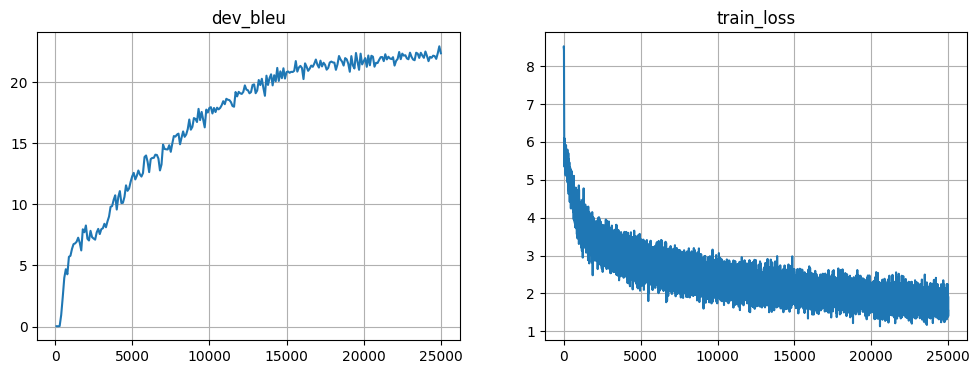

Mean loss=1.646


100%|██████████| 25000/25000 [39:25<00:00, 10.57it/s]


In [23]:
model = LSTMAttentiveModel(inp_voc, out_voc).to(device)
metrics = train_model(model)

### Final BLEU

In [24]:
compute_bleu(model, dev_inp, dev_out)

22.352002214950986

In [25]:
for inp_line, trans_line in zip(dev_inp[::500], model.translate_lines(dev_inp[::500])[0]):
    print(inp_line)
    print(trans_line)
    print()

в распоряжении гостей общая кухня и общая гостиная .
you will find a shared kitchen and a shared room .

кроме того , предоставляется прокат велосипедов , услуги трансфера и бесплатная парковка .
bicycle rental is available , and guests can also rent free parking .

расстояние до города ки@@ сси@@ м@@ ми составляет 26 км .
mono@@ poli is 26 km away .

апартаменты в пент@@ хаусе с общим открытым бассейном , садом , кондиционером и террасой для загара расположены в 5 минутах ходьбы от пляжа на курорте ка@@ бо - рой .
located in a 5 - minute walk from the beach in the centre of the beach , this apartment features a quiet , furnished living room and a terrace .

апартаменты mo@@ s@@ co@@ w point - loft red square находятся в москве , в 200 метрах от большого театра .
located 200 metres from the city ’ s centre of the city , the cycladic - style apartment is located in the centre of kotor .

в вашем распоряжении собственная ванная комната с душем и полотенцами .
featuring a shower , private

## RNN based attention model

In [26]:
class RNNAttentiveModel(BasicModel):
    def __init__(self, inp_voc, out_voc,
                 emb_size=64, hid_size=128, attn_size=128):
        """ Translation model that uses attention. See instructions above. """
        nn.Module.__init__(self)  # initialize base class to track sub-layers, trainable variables, etc.
        super().__init__(inp_voc, out_voc)
        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size
        self.enc0 = nn.RNN(emb_size, hid_size, batch_first=True)
        self.dec0 = nn.RNNCell(emb_size, hid_size)
        self.attention = AttentionLayer('dec_attention', hid_size, hid_size, hid_size=attn_size)
        self.dec_linear = nn.Linear(2 * hid_size, hid_size)
        
        

    def encode(self, inp, **flags):
        """
        Takes symbolic input sequence, computes initial state
        :param inp: matrix of input tokens [batch, time]
        :return: a list of initial decoder state tensors
        """
        
        # encode input sequence, create initial decoder states
        inp_emb = self.emb_inp(inp)
        batch_size = inp.shape[0]
        enc_seq, [last_state_but_not_really] = self.enc0(inp_emb)
        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]
        dec_start = self.dec_start(last_state)
        dec_start_zeroes = torch.zeros_like(dec_start)
        
        enc_mask = model.inp_voc.compute_mask(inp)
        
        # apply attention layer from initial decoder hidden state
        first_attn_result, first_attn_probas = self.attention(enc_seq, dec_start_zeroes, enc_mask)
        
        # Build first state: include
        # * initial states for decoder recurrent layers
        # * encoder sequence and encoder attn mask (for attention)
        # * make sure that last state item is attention probabilities tensor
        
        first_state = [dec_start, first_attn_result, enc_seq, enc_mask, first_attn_probas]
        return first_state
   
    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Takes previous decoder state and tokens, returns new state and logits for next tokens
        :param prev_state: a list of previous decoder state tensors
        :param prev_tokens: previous output tokens, an int vector of [batch_size]
        :return: a list of next decoder state tensors, a tensor of logits [batch, n_tokens]
        """
        [prev_dec_state, prev_attn_result, enc_seq, enc_mask, prev_attn_probas] = prev_state


        prev_plus_attn = self.dec_linear(torch.cat((prev_attn_result, prev_dec_state), dim = 1))
        
        new_dec_state, output_logits = super().decode_step([prev_plus_attn], prev_tokens)
        
        new_attn_result, new_attn_probas = self.attention(enc_seq, new_dec_state[0], enc_mask)
        
        full_state = [new_dec_state[0], new_attn_result, enc_seq, enc_mask, new_attn_probas]
        return [full_state, output_logits]


In [27]:
# debugging area
model = RNNAttentiveModel(inp_voc, out_voc).to(device)

dummy_inp_tokens = inp_voc.to_matrix(sorted(train_inp, key=len)[5:10]).to(device)
dummy_out_tokens = out_voc.to_matrix(sorted(train_out, key=len)[5:10]).to(device)

h0 = model.encode(dummy_inp_tokens)
h1, logits1 = model.decode_step(h0, torch.arange(len(dummy_inp_tokens), device=device))


logits_seq = model.decode(h0, dummy_out_tokens)
assert logits_seq.shape == (dummy_out_tokens.shape[0], dummy_out_tokens.shape[1], len(out_voc))

# # full forward
logits_seq2 = model(dummy_inp_tokens, dummy_out_tokens)
assert logits_seq2.shape == logits_seq.shape

In [28]:
compute_bleu(model, dev_inp, dev_out)

0.002163408567114131

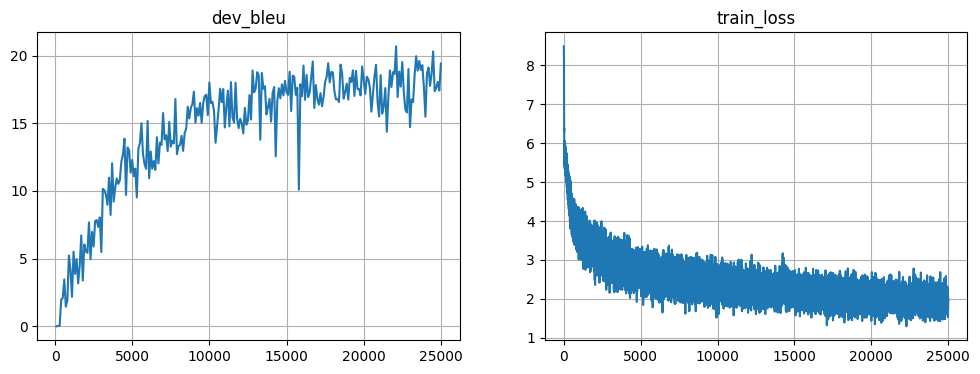

Mean loss=1.919


100%|██████████| 25000/25000 [38:52<00:00, 10.72it/s]


In [29]:
model = RNNAttentiveModel(inp_voc, out_voc).to(device)
metrics = train_model(model)

### Final BLEU

In [30]:
compute_bleu(model, dev_inp, dev_out)

19.409394990132853

In [31]:
for inp_line, trans_line in zip(dev_inp[::500], model.translate_lines(dev_inp[::500])[0]):
    print(inp_line)
    print(trans_line)
    print()

в распоряжении гостей общая кухня и общая гостиная .
there is a shared kitchen and a shared kitchen .

кроме того , предоставляется прокат велосипедов , услуги трансфера и бесплатная парковка .
the property offers bike rental , free parking .

расстояние до города ки@@ сси@@ м@@ ми составляет 26 км .
the town of the city of the town of the town is 26 km away .

апартаменты в пент@@ хаусе с общим открытым бассейном , садом , кондиционером и террасой для загара расположены в 5 минутах ходьбы от пляжа на курорте ка@@ бо - рой .
a 5 - minute walk from the beach in the centre of the santa cruz .

апартаменты mo@@ s@@ co@@ w point - loft red square находятся в москве , в 200 метрах от большого театра .
the church of saint john is 200 metres from the property .

в вашем распоряжении собственная ванная комната с душем и полотенцами .
the private bathroom comes with a shower and towels .



## Bidirectional encoder + GRU for both

In [87]:
class BidirEncAttentiveModel(BasicModel):
    def __init__(self, inp_voc, out_voc,
                 emb_size=64, hid_size=128, attn_size=128):
        """ Translation model that uses attention. See instructions above. """
        nn.Module.__init__(self)  # initialize base class to track sub-layers, trainable variables, etc.
        super().__init__(inp_voc, out_voc)
        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size
        self.enc0 = nn.GRU(emb_size, hid_size, batch_first=True, bidirectional=True)
        self.dec0 = nn.GRUCell(emb_size, 2 * hid_size)
        self.dec_start = nn.Linear(2 * hid_size, 2 * hid_size)
        self.attention = AttentionLayer('dec_attention', 2 * hid_size, 2 * hid_size, hid_size=attn_size)
        self.dec_linear = nn.Linear(4 * hid_size, 2 * hid_size)
        
        self.logits = nn.Linear(2 * hid_size, len(out_voc))
        
        

    def encode(self, inp, **flags):
        """
        Takes symbolic input sequence, computes initial state
        :param inp: matrix of input tokens [batch, time]
        :return: a list of initial decoder state tensors
        """
        
        # encode input sequence, create initial decoder states
        inp_emb = self.emb_inp(inp)
        batch_size = inp.shape[0]
        enc_seq, _ = self.enc0(inp_emb)
        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]
        dec_start = self.dec_start(last_state)
        
        enc_mask = model.inp_voc.compute_mask(inp)
        
        # apply attention layer from initial decoder hidden state
        first_attn_result, first_attn_probas = self.attention(enc_seq, dec_start, enc_mask)
        
        # Build first state: include
        # * initial states for decoder recurrent layers
        # * encoder sequence and encoder attn mask (for attention)
        # * make sure that last state item is attention probabilities tensor
        
        first_state = [dec_start, first_attn_result, enc_seq, enc_mask, first_attn_probas]
        return first_state
   
    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Takes previous decoder state and tokens, returns new state and logits for next tokens
        :param prev_state: a list of previous decoder state tensors
        :param prev_tokens: previous output tokens, an int vector of [batch_size]
        :return: a list of next decoder state tensors, a tensor of logits [batch, n_tokens]
        """
        [prev_dec_state, prev_attn_result, enc_seq, enc_mask, prev_attn_probas] = prev_state

        prev_plus_attn = self.dec_linear(torch.cat((prev_attn_result, prev_dec_state), dim = 1))

        
        new_dec_state, output_logits = super().decode_step([prev_plus_attn], prev_tokens)
        
        new_attn_result, new_attn_probas = self.attention(enc_seq, new_dec_state[0], enc_mask)
        
        full_state = [new_dec_state[0], new_attn_result, enc_seq, enc_mask, new_attn_probas]
        return [full_state, output_logits]

In [88]:
# debugging area
model = BidirEncAttentiveModel(inp_voc, out_voc).to(device)

dummy_inp_tokens = inp_voc.to_matrix(sorted(train_inp, key=len)[5:10]).to(device)
dummy_out_tokens = out_voc.to_matrix(sorted(train_out, key=len)[5:10]).to(device)

h0 = model.encode(dummy_inp_tokens)
h1, logits1 = model.decode_step(h0, torch.arange(len(dummy_inp_tokens), device=device))


logits_seq = model.decode(h0, dummy_out_tokens)
assert logits_seq.shape == (dummy_out_tokens.shape[0], dummy_out_tokens.shape[1], len(out_voc))

# # full forward
logits_seq2 = model(dummy_inp_tokens, dummy_out_tokens)
assert logits_seq2.shape == logits_seq.shape

In [89]:
compute_bleu(model, dev_inp, dev_out)

0.0016520282781050547

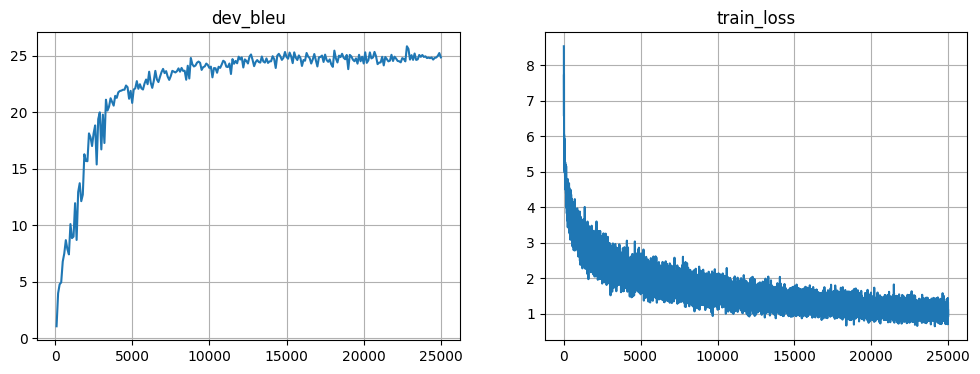

Mean loss=1.064


100%|██████████| 25000/25000 [44:52<00:00,  9.29it/s]


In [90]:
model = BidirEncAttentiveModel(inp_voc, out_voc).to(device)
metrics = train_model(model)

In [91]:
compute_bleu(model, dev_inp, dev_out)

24.8600597758939

In [78]:
for inp_line, trans_line in zip(dev_inp[::500], model.translate_lines(dev_inp[::500])[0]):
    print(inp_line)
    print(trans_line)
    print()

в распоряжении гостей общая кухня и общая гостиная .
there is a shared kitchen and a common kitchen .

кроме того , предоставляется прокат велосипедов , услуги трансфера и бесплатная парковка .
bicycle rental and shuttle services are available for rent and bicycle rental .

расстояние до города ки@@ сси@@ м@@ ми составляет 26 км .
cal@@ r is about 45 km away .

апартаменты в пент@@ хаусе с общим открытым бассейном , садом , кондиционером и террасой для загара расположены в 5 минутах ходьбы от пляжа на курорте ка@@ бо - рой .
located 5 minutes ' walk from the beach in viña , this air - conditioned apartment features a garden and a sun terrace . it features a garden and a sun terrace . it features a garden and a sun terrace . it features a garden and a sun terrace . it features a garden and a sun terrace . it features a garden and a sun terrace . it features a garden and a sun terrace . it features a garden and a sun terrace . it features a garden and a sun terrace . it features a garden

## Multihead Attention + Bidirectional Encoder + GRU

In [100]:
class MultiHeadAttentiveModel(BasicModel):
    def __init__(self, inp_voc, out_voc,
                 emb_size=64, hid_size=128, attn_sizes=[128, 256, 256, 512]):
        """ Translation model that uses attention. See instructions above. """
        nn.Module.__init__(self)  # initialize base class to track sub-layers, trainable variables, etc.
        super().__init__(inp_voc, out_voc)
        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size
        self.enc0 = nn.GRU(emb_size, hid_size, batch_first=True, bidirectional=True)
        self.dec0 = nn.GRUCell(emb_size, 2 * hid_size)
        self.dec_start = nn.Linear(2 * hid_size, 2 * hid_size)
        self.attention_1 = AttentionLayer('dec_attention1', 2 * hid_size, 2 * hid_size, hid_size=attn_sizes[0])
        self.attention_2 = AttentionLayer('dec_attention2', 2 * hid_size, 2 * hid_size, hid_size=attn_sizes[1])
        self.attention_3 = AttentionLayer('dec_attention3', 2 * hid_size, 2 * hid_size, hid_size=attn_sizes[2])
        self.attention_4 = AttentionLayer('dec_attention4', 2 * hid_size, 2 * hid_size, hid_size=attn_sizes[3])
        self.attention_lin = nn.Linear(8 * hid_size, 2 * hid_size)
        self.dec_linear = nn.Linear(4 * hid_size, 2 * hid_size)
        
        self.logits = nn.Linear(2 * hid_size, len(out_voc))
        
        

    def encode(self, inp, **flags):
        """
        Takes symbolic input sequence, computes initial state
        :param inp: matrix of input tokens [batch, time]
        :return: a list of initial decoder state tensors
        """
        
        # encode input sequence, create initial decoder states
        inp_emb = self.emb_inp(inp)
        batch_size = inp.shape[0]
        enc_seq, _ = self.enc0(inp_emb)
        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]
        dec_start = self.dec_start(last_state)
        
        enc_mask = model.inp_voc.compute_mask(inp)
        
        # apply attention layer from initial decoder hidden state
        first_attn_result_1, _ = self.attention_1(enc_seq, dec_start, enc_mask)
        first_attn_result_2, _ = self.attention_2(enc_seq, dec_start, enc_mask)
        first_attn_result_3, _ = self.attention_3(enc_seq, dec_start, enc_mask)
        first_attn_result_4, _ = self.attention_4(enc_seq, dec_start, enc_mask)

        attn_result =  self.attention_lin(torch.cat((first_attn_result_1, 
                                                     first_attn_result_2, 
                                                     first_attn_result_3, 
                                                     first_attn_result_4), dim=1))
        
        # Build first state: include
        # * initial states for decoder recurrent layers
        # * encoder sequence and encoder attn mask (for attention)
        # * make sure that last state item is attention probabilities tensor
        
        first_state = [dec_start, attn_result, enc_seq, enc_mask]
        return first_state
   
    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Takes previous decoder state and tokens, returns new state and logits for next tokens
        :param prev_state: a list of previous decoder state tensors
        :param prev_tokens: previous output tokens, an int vector of [batch_size]
        :return: a list of next decoder state tensors, a tensor of logits [batch, n_tokens]
        """
        [prev_dec_state, prev_attn_result, enc_seq, enc_mask] = prev_state

        prev_plus_attn = self.dec_linear(
            torch.cat((prev_attn_result, prev_dec_state), dim = 1))

        
        new_dec_state, output_logits = super().decode_step([prev_plus_attn], prev_tokens)
        
        new_attn_result_1, _ = self.attention_1(enc_seq, new_dec_state[0], enc_mask)
        new_attn_result_2, _ = self.attention_2(enc_seq, new_dec_state[0], enc_mask)
        new_attn_result_3, _ = self.attention_3(enc_seq, new_dec_state[0], enc_mask)
        new_attn_result_4, _ = self.attention_4(enc_seq, new_dec_state[0], enc_mask)

        attn_result =  self.attention_lin(torch.cat((new_attn_result_1, 
                                                     new_attn_result_2, 
                                                     new_attn_result_3, 
                                                     new_attn_result_4), dim=1))
        
        full_state = [new_dec_state[0], attn_result, enc_seq, enc_mask]
        return [full_state, output_logits]

In [101]:
# debugging area
model = MultiHeadAttentiveModel(inp_voc, out_voc).to(device)

dummy_inp_tokens = inp_voc.to_matrix(sorted(train_inp, key=len)[5:10]).to(device)
dummy_out_tokens = out_voc.to_matrix(sorted(train_out, key=len)[5:10]).to(device)

h0 = model.encode(dummy_inp_tokens)
h1, logits1 = model.decode_step(h0, torch.arange(len(dummy_inp_tokens), device=device))


logits_seq = model.decode(h0, dummy_out_tokens)
assert logits_seq.shape == (dummy_out_tokens.shape[0], dummy_out_tokens.shape[1], len(out_voc))

# # full forward
logits_seq2 = model(dummy_inp_tokens, dummy_out_tokens)
assert logits_seq2.shape == logits_seq.shape

In [102]:
compute_bleu(model, dev_inp, dev_out)

0.001675865787003573

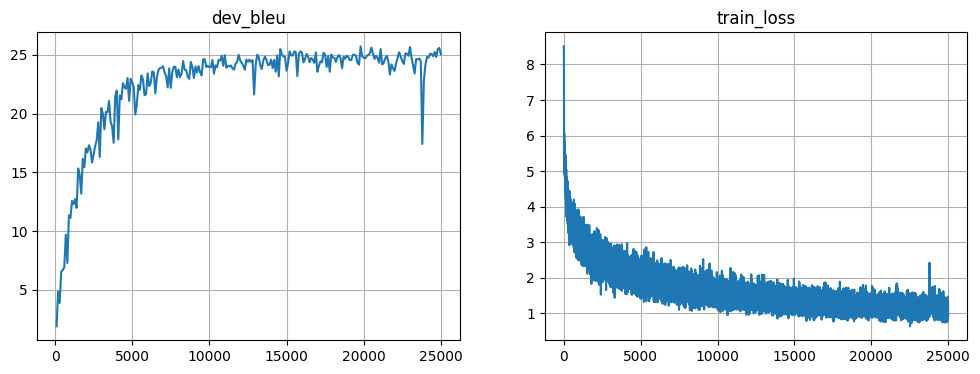

Mean loss=1.083


100%|██████████| 25000/25000 [2:09:15<00:00,  3.22it/s]


In [103]:
model = MultiHeadAttentiveModel(inp_voc, out_voc).to(device)
metrics = train_model(model)

In [104]:
compute_bleu(model, dev_inp, dev_out)

25.054259779275554

In [105]:
for inp_line, trans_line in zip(dev_inp[::500], model.translate_lines(dev_inp[::500])[0]):
    print(inp_line)
    print(trans_line)
    print()

в распоряжении гостей общая кухня и общая гостиная .
guests can use a shared kitchen at the property you will find a shared lounge and shared lounge .

кроме того , предоставляется прокат велосипедов , услуги трансфера и бесплатная парковка .
bicycle rental and shuttle service are available .

расстояние до города ки@@ сси@@ м@@ ми составляет 26 км .
kissimmee is 26 km from the property .

апартаменты в пент@@ хаусе с общим открытым бассейном , садом , кондиционером и террасой для загара расположены в 5 минутах ходьбы от пляжа на курорте ка@@ бо - рой .
offering a shared outdoor pool , a tennis court and a terrace , this air - conditioned apartment features a shared outdoor pool , a terrace and a terrace , the air - conditioned apartment features a shared outdoor pool .

апартаменты mo@@ s@@ co@@ w point - loft red square находятся в москве , в 200 метрах от большого театра .
mo@@ ni@@ s apartment is located in moscow , 200 metres from mos@@ cov@@ ina .

в вашем распоряжении собственна